<div style="background-color: #f0f2f5; padding: 20px; border-radius: 10px; border-left: 10px solid #20beff;">
    <h1 style="color: #1c1c1c; margin-bottom: 5px;">生徒のテスト点数予測：日本語学習者のためのシンプルなCatBoost入門</h1>
    <p style="color: #666;">経済学の視点を取り入れた特徴量設計とその検証</p>
</div>

In [6]:
# !pip install pandas numpy matplotlib seaborn scikit-learn catboost

In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

In [8]:
# ----------------------------------------------------------------
# カラム名の正規化関数
# ----------------------------------------------------------------
def normalize_columns(df):
    """
    カラム名の空白をアンダースコアに置換し、小文字化。重複カラムも削除。
    """
    df.columns = [c.replace(' ', '_').strip().lower() for c in df.columns]
    return df.loc[:, ~df.columns.duplicated()]

# ----------------------------------------------------------------
# データの読み込み
# ----------------------------------------------------------------
# ※ Kaggle環境で実行する場合はパスを "/kaggle/input/..." に書き換えてください
trn_df = pd.read_csv("KaggleData/playground-series-s6e1/train.csv")
test_df = pd.read_csv("KaggleData/playground-series-s6e1/test.csv")
orig_df = pd.read_csv("KaggleData/playground-series-s6e1/StudentPerformanceFactors.csv")

# 全データフレームを一括で正規化
trn_df = normalize_columns(trn_df)
test_df = normalize_columns(test_df)
orig_df = normalize_columns(orig_df)

# ----------------------------------------------------------------
# 外部データ (Original Dataset) の調整
# ----------------------------------------------------------------
# コンペの元データを引っ張ってくる際、カラムの名前が違うので調整します


rename_map = {
    'hours_studied': 'study_hours',
    'attendance': 'class_attendance',
}
orig_df = orig_df.rename(columns=rename_map)

# 元データの、カテゴリ値の表記ゆれ（大文字小文字）を統一
#  元データでは maleが Maleなど、大文字になっています
cat_cols = ['gender', 'internet_access']
for col in cat_cols:
    for df in [trn_df, test_df, orig_df]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower()

# ----------------------------------------------------------------
# 順序変数のエンコーディング (Ordinal Encoding)
# ----------------------------------------------------------------
ordinal_maps = {
    "sleep_quality": {"poor": 0, "average": 1, "good": 2},
    "facility_rating": {"low": 0, "medium": 1, "high": 2},
    "exam_difficulty": {"easy": 0, "moderate": 1, "hard": 2},
    "internet_access": {"no": 0, "yes": 1}
}

for df in [trn_df, test_df, orig_df]:
    for col, mapping in ordinal_maps.items():
        if col in df.columns:
            # 元の値を活かしつつ、計算用の数値カラムを追加
            df[f"{col.split('_')[0]}_num"] = df[col].map(mapping)

# ----------------------------------------------------------------
# データの結合
# ----------------------------------------------------------------
# データの出自を区別するフラグを追加
trn_df['is_original'] = 0
orig_df['is_original'] = 1
test_df['is_original'] = 0

# 共通のカラムのみを抽出して結合
common_cols = list(set(trn_df.columns) & set(orig_df.columns))
train_df = pd.concat([trn_df, orig_df[common_cols]], axis=0, ignore_index=True)

seed = 42

print(f"Combined Train Shape: {train_df.shape}")

Combined Train Shape: (636607, 18)


In [9]:
# ----------------------------------------------------------------
# 特徴量の作成
# ----------------------------------------------------------------
def make_features(df):
    # 学習時間が一定（7時間）以上かどうかのフラグ
    df['high_study'] = (df['study_hours'] >= 7).astype(int)
    # 二乗項：限界効用の変化を考慮
    df['study_hours_sq'] = df['study_hours'] ** 2
    df['class_attendance_sq'] = df['class_attendance'] ** 2
    # 活動時間と自由時間の算出
    df['active_hours']        = 24 - df["sleep_hours"]
    df['free_time']         = df['active_hours'] - df['study_hours']       
    return df
    
# 特徴量生成の適用
train_df = make_features(train_df)
test_df = make_features(test_df)

# ----------------------------------------------------------------
# ターゲットエンコーディング (Smoothing適用版)
# ----------------------------------------------------------------
def target_encode_smooth(df, col, target, m=20):
    """
    データの少ないカテゴリが極端な値にならないよう、全体平均に寄せる(Smoothing)処理
    """
    global_mean = df[target].mean()
    stats = df.groupby(col)[target].agg(['mean','count'])

    # Smoothing公式: (カテゴリ平均 * カウント + 全体平均 * m) / (カウント + m)
    smooth = (stats['count'] * stats['mean'] + m * global_mean) / (stats['count'] + m)
    return smooth

# 交差検証(CV)を用いたターゲットエンコーディング
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
overall_mean = train_df['exam_score'].mean()

for col in ["course", "study_method"]:
    new_col = f"{col}_te"
    train_df[new_col] = 0

    # リーク防止のため、Foldごとにエンコーディングを計算
    for tr_idx, val_idx in kf.split(train_df):
        smooth_map = target_encode_smooth(
            train_df.iloc[tr_idx], col, "exam_score", m=20
        )
        train_df.loc[val_idx, new_col] = train_df.loc[val_idx, col].map(smooth_map)
        
    # 欠損値は全体平均で補完
    train_df[new_col] = train_df[new_col].fillna(overall_mean)

    # テストデータ用には、学習データ全体から作成したマップを適用
    smooth_map = target_encode_smooth(train_df, col, "exam_score", m=20)
    test_df[new_col] = test_df[col].map(smooth_map).fillna(overall_mean)

In [10]:
# ----------------------------------------------------------------
# 特徴量の選択と整理
# ----------------------------------------------------------------
# 不要なカラムやターゲット変数を削除
drop_cols = ["id", "age", "study_method", "course"]

X = train_df.drop(["exam_score"] + [c for c in drop_cols if c in train_df.columns], axis=1)
X_test = test_df.drop([c for c in drop_cols if c in test_df.columns] + ["id"], axis=1)
y = train_df["exam_score"]

# ★最重要：訓練データとテストデータの列順を完全に一致させる
X_test = X_test[X.columns]

# CatBoostに教えるカテゴリ変数のリスト
cat_features = ["gender", "internet_access", "sleep_quality", "facility_rating", "exam_difficulty"]

# カテゴリ変数を文字列型に変換（CatBoostの要件）
for col in cat_features:
    X[col] = X[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [11]:
# ----------------------------------------------------------------
# 5-Fold Cross Validation による学習
# ----------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof = np.zeros(len(X)) # Out-of-Fold 予測値の格納用
test_preds = np.zeros(len(X_test)) # テストデータの予測値格納用

for fold, (tr_idx, val_idx) in enumerate(kf.split(X)):
    print(f"--- Fold {fold+1} ---")

    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    # モデルの設定
    model = CatBoostRegressor(
        iterations=8000,
        learning_rate=0.03,
        depth=5,
        loss_function="RMSE",
        random_seed=42,
        subsample=0.8,
        verbose=400, # 400回ごとにログを表示
        early_stopping_rounds=200
    )

    # 学習実行
    model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        cat_features=cat_features,
        use_best_model=True
    )

    # 予測（検証データとテストデータ）
    oof[val_idx] = model.predict(X_val)
    test_preds += model.predict(X_test) / kf.n_splits

# ----------------------------------------------------------------
# 全体の評価
# ----------------------------------------------------------------
rmse = np.sqrt(mean_squared_error(y, oof))
print(f"\nFinal OOF RMSE: {rmse:.4f}")

--- Fold 1 ---
0:	learn: 18.4862624	test: 18.4483320	best: 18.4483320 (0)	total: 109ms	remaining: 14m 32s
400:	learn: 8.8009142	test: 8.7993088	best: 8.7993088 (400)	total: 18s	remaining: 5m 41s
800:	learn: 8.7723075	test: 8.7746422	best: 8.7746422 (800)	total: 36s	remaining: 5m 23s
1200:	learn: 8.7535114	test: 8.7599566	best: 8.7599566 (1200)	total: 54.4s	remaining: 5m 7s
1600:	learn: 8.7391732	test: 8.7500734	best: 8.7500734 (1600)	total: 1m 12s	remaining: 4m 51s
2000:	learn: 8.7270514	test: 8.7425076	best: 8.7425076 (2000)	total: 1m 31s	remaining: 4m 35s
2400:	learn: 8.7164821	test: 8.7365226	best: 8.7365226 (2400)	total: 1m 50s	remaining: 4m 18s
2800:	learn: 8.7068776	test: 8.7312152	best: 8.7312152 (2800)	total: 2m 11s	remaining: 4m 3s
3200:	learn: 8.6983713	test: 8.7274331	best: 8.7274331 (3200)	total: 2m 30s	remaining: 3m 45s
3600:	learn: 8.6904088	test: 8.7238277	best: 8.7238277 (3600)	total: 2m 49s	remaining: 3m 26s
4000:	learn: 8.6833719	test: 8.7213053	best: 8.7213053 (4000)

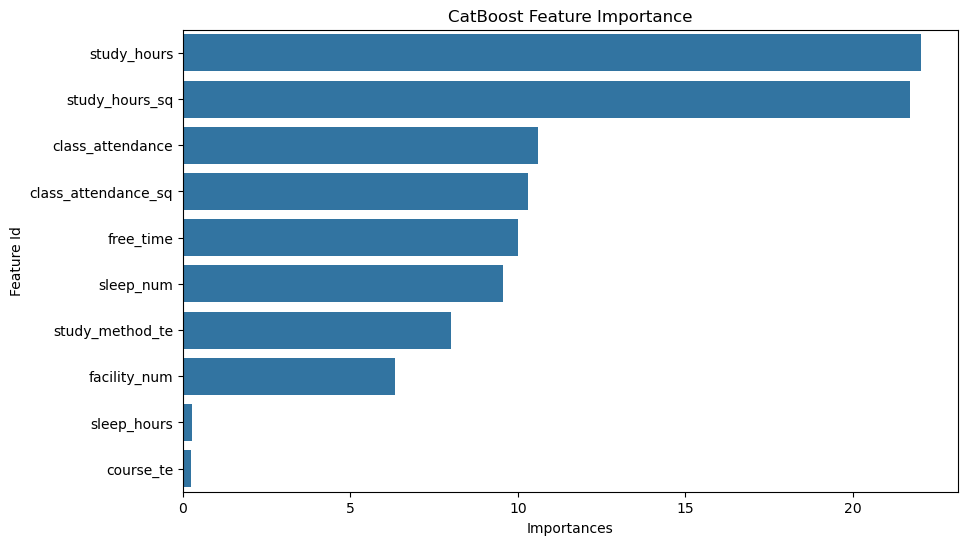

In [13]:
import matplotlib.pyplot as plt

# 特徴量重要度の取得
feat_imp = model.get_feature_importance(prettified=True)

# 上位10個を表示
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feat_imp.head(10))
plt.title("CatBoost Feature Importance")
plt.show()

In [12]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "exam_score": test_preds
})
submission.to_csv("submission.csv", index=False)
print("Submission file created!")

Submission file created!
